In [31]:
# Required packages
!pip install vega_datasets
!pip install keybert
!pip install sentence-transformers
!pip install spacy
!pip install wordcloud
!pip install matplotlib
!python -m spacy download en_core_web_sm 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 59.8 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [19]:
import http.client
import json
import re

import pandas as pd

from collections import defaultdict
from sentence_transformers import SentenceTransformer
from keybert import KeyBERT

import numpy as np
import spacy

from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [20]:
# inputs

volume_id = 'osu.32436000578904'
# Connect to the HTRC API
conn = http.client.HTTPSConnection("tools.htrc.illinois.edu")

# Set the headers for the API request
headers = { 'Content-Type': "application/json" }

key_word_model = KeyBERT('distilbert-base-nli-mean-tokens')
sentences_model = SentenceTransformer('sentence-transformers/sentence-t5-base')

In [21]:
# Main fuctions

filter_out = ['<', '>', '(', ')', '[', ']', '{', '}', '!', '@', '#', '$', '%', '^', '&', '*', '_', '+', '=', '|', '\\',
              '/', '?', ',', '.', ';', ':', '"', "'", ' ',
              'IN', 'CC', 'CD', 'SYM']

def retrieve_data(conn, headers, volume_id):
    ''' Given the API connection retrieve a JSON with the data'''

    # Make an API request to get information about the volumes in the workset
    conn.request("GET", f"/ef-api/volumes/{volume_id}/pages", headers=headers)

    # Get the response and parse the data
    res = conn.getresponse()
    data = res.read()
    
    # Initialize variables to store total token count, total unique word count, and other metrics
    data = json.loads(data.decode("utf-8"))

    return data

def generate_plain_text(token_pos_count):
    ''' Generate plain texts'''
    token_cleaned = []

    for token in token_pos_count:
        for tag in token_pos_count[token]:
            if tag not in filter_out:
                token_cleaned.append(token)
    return token_cleaned

# Retrieving Data
def get_text_per_pages(record):
    '''' Reconstruct the text inside the pages'''
    
    data = {}
    for page in record['data']['pages']:
        if page['body']:
            if page['body']['tokenCount'] > 15:

                page_text = generate_plain_text(page['body']['tokenPosCount'])
                if len(page_text) > 15:
                    # Use the page for similarity analysis
                    data[page['seq']] = ' '.join(page_text)
                    # Use the page for similarity analysis
                    #data.append({'page_no': page['seq'], 'text': ' '.join(page_text)})


    return data

def tokens_per_pages_count(record):
    ''' Create the list of words per page and how many time the word is mentioned '''

    word_key_count = []
    
    for page in record['data']['pages']:
        if page['body']:
            for token, pos_count in page['body']['tokenPosCount'].items():
                word_key_count.append({'token': token, 'page_no': page['seq'].strip("0"), 'count': list(pos_count.values())[0]})
                    
    return word_key_count

def get_keywords(text):
    keywords = key_word_model.extract_keywords(text, top_n=10)
    return keywords


def get_key_words_by_page(data: dict) -> dict:
    pages_keywords = {}
    for page in data:
        keywords = get_keywords(data[page])
        pages_keywords[page] = keywords

    return pages_keywords

def extract_relevant_pages(data, query_embedding):
    page_similarities = {}
    for idx, items in enumerate(data.items()):
        #print(f"Page {idx} - {items[1]}\n")

        # Calculate the similarity between the query and the pages
        cosine_similarities = np.dot(list_embeddings[idx, :], query_embedding[0])
        #print(cosine_similarities)
        page_similarities[items[0]] = cosine_similarities
    document_attributes = [
        {'page_no': key.strip("0"), 'text': value, 'key_terms': pages_keywords[key], 'score': page_similarities[key]} for
        key, value in data.items()]

    return sorted(document_attributes, key=lambda x: x['page_no'], reverse=True)

def text_lemmatizer(text):

    # English pipelines include a rule-based lemmatizer
    nlp = spacy.load("en_core_web_sm")
    lemmatizer = nlp.get_pipe("lemmatizer")
    #print(lemmatizer.mode)  # 'rule'
    
    doc = nlp(text)
    
    return ([token.lemma_ for token in doc])
    # ['I', 'be', 'read', 'the', 'paper', '.']


In [22]:
# Raw data from the API
data = retrieve_data(conn, headers, volume_id)

# Dictionary that reconstructs the text at page level
page_dataset = get_text_per_pages(data)

# List of list of token, page_no and token count per page
count_words = tokens_per_pages_count(data)

# I want to find mentions related to this query
query_term = "how the childrem learn?"

# Create the embedding for the query
query_embedding = sentences_model.encode([query_term])

# Create the embeddings for each page
list_texts = list(page_dataset.values())
list_embeddings = sentences_model.encode(list_texts)

#print(list_texts)

#df = pd.DataFrame(page_dataset)

#df_text = df['text'].to_list()
#df_page_no = df['page_no'].to_list()


# Create the embeddings for each page
list_texts = list(page_dataset.values())
#print(list_texts)
list_embeddings = sentences_model.encode(list_texts)

# Extract the top 10 key words of each pages
pages_keywords = get_key_words_by_page(page_dataset)
print(pages_keywords['00000004'])

[('iiilllllllllllllllllllllllllllllllllllllllllllllllllllllllllllll', 0.729), ('zºzº', 0.6489), ('zºº', 0.6078), ('lº', 0.5772), ('rº', 0.5728), ('hºº', 0.5593), ('oxº', 0.5472), ('tº', 0.5384), ('assºº', 0.5204), ('ºu', 0.4859)]


In [23]:
# Create a dataset with the key words and the relevant page
relevant_pages_dataset = extract_relevant_pages(page_dataset, query_embedding)

relevant_pages_dataset[0:3]

[{'page_no': '99',
  'text': 'exploit ways subsequent method ego-involvement author begin any lead babies this have learned your exploitation bottles are is learn rightful his require lips hard try They Sucking sit sure convenience demonstrating what opportunities suggested You own up normal him drinking drinking ready held parents Babies opportunity persuaded three-year-olds a intention earlier juice well has sips feeding old quite advantage strong There cup they way helping trained amount breast drink encourage to purpose getting satisfying you inadvertently Parents child small most most spoon trainer The often can how take who sufficient them fill think he mature should cups new will liquids chronic much their satisfactions not ability grows fluids easily give first alone baby could Do oral thus sucking putting an attained be skill always time thumb-sucking were glasses more form preparation glass Children Such no very attachments needs steadily when known Opportunities instructed p

In [24]:
df_relevant_pages = pd.DataFrame.from_records(relevant_pages_dataset) #[0:5000]

# Filter out pages with lower score
df_relevant_pages = df_relevant_pages[df_relevant_pages['score'] > 0.83] 

# Create a list with the relevant page
list_relevant_pages = [page.strip("0") for page in df_relevant_pages['page_no'].to_list()]

In [25]:
df = pd.DataFrame.from_records(count_words) 

relevant_count_words = df[df['page_no'].isin(list_relevant_pages)]
relevant_count_words
len(relevant_count_words)

5332

In [26]:
df_relevant_pages['key_terms'].to_list()[0:0]

[]

In [27]:
list_key_term = set([key_term[0][0] for key_term in df_relevant_pages['key_terms'].to_list()])


relevant_count_words = df[df['token'].isin(list_key_term)]

In [28]:
df = pd.DataFrame.from_records(count_words) 
df

,token,page_no,count
0,|,1,1
1,-,1,45
2,Fo,2,1
3,IIIII,2,1
4,|,2,4
...,...,...,...
36932,Ohio,258,1
36933,§,258,1
36934,mi,258,1
36935,PAREN,258,1


In [29]:
# To use this visualization we should create a dataset with the following columns Keyword, Page, Count (How many times it appears per page)

import altair as alt
from vega_datasets import data


alt.Chart(relevant_count_words[relevant_count_words['count']>1]).mark_circle(
    opacity=0.8,
    stroke='black',
    strokeWidth=1,
    strokeOpacity=0.4
).encode(
    alt.X('page_no:Q') # quantitative data
        .title(None)
        .scale(domain=['0', str(df['page_no'].nunique())]),
    alt.Y('token:N') # nominal data
        .title(None),
    alt.Size('count:Q')
        .scale(range=[50, 300])
        .title('count'),
    alt.Color('token:N').legend(None),
    tooltip=[
        #"token:N",
        alt.Tooltip("page_no:Q"),
        alt.Tooltip("count:Q")
    ],
).properties(
    width=450,
    height=320,
    title=alt.Title(
        text="Global Deaths from Natural Disasters (1900-2017)",
        subtitle="The size of the bubble represents the total death count per year, by type of disaster",
        anchor='start'
    )
).configure_axisY(
    domain=False,
    ticks=False,
    offset=10
).configure_axisX(
    grid=False,
).configure_view(
    stroke=None
)

alt.Chart(...)

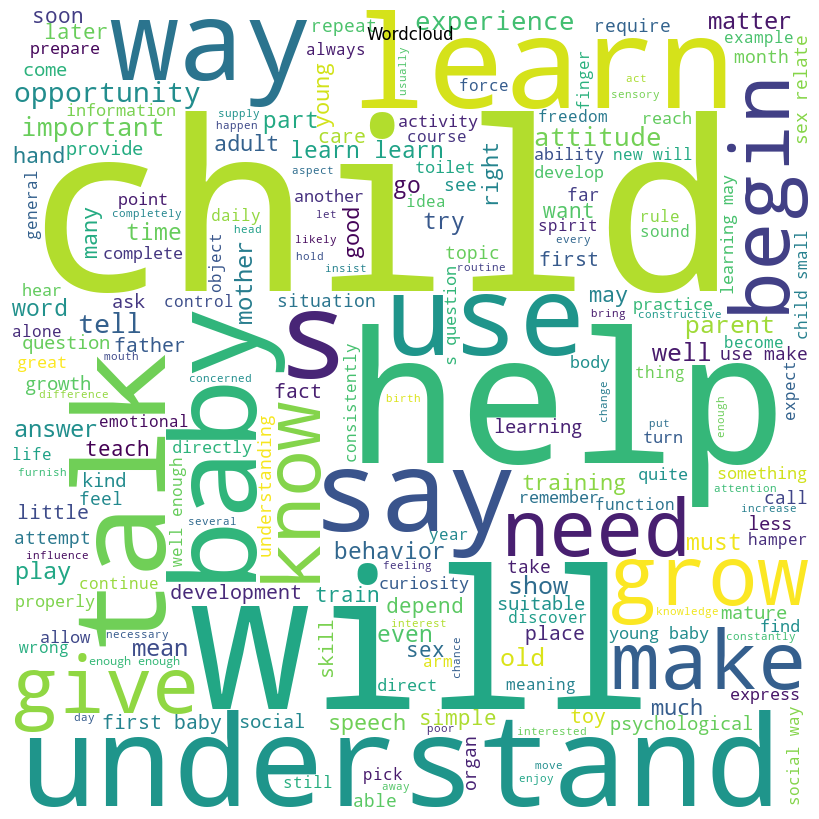

In [32]:
# Lemmatize the text of relevant pages to generate a wordcloud
list_relevant_pages = relevant_count_words['page_no'].unique()


df_text_relevant_pages = df_relevant_pages[df_relevant_pages['page_no'].isin(list_relevant_pages)]
lemmatize_relevant_pages = ''
for text_page in df_text_relevant_pages['text'].to_list():
    lemmatize_page = text_lemmatizer(text_page)
    lemmatize_relevant_pages = lemmatize_relevant_pages + ' '.join(lemmatize_page)


def generate_wordcloud(text, title="Wordcloud"):
    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = None,
                min_font_size = 10).generate(text)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.suptitle(title)
    plt.show()

generate_wordcloud(lemmatize_relevant_pages, title="Wordcloud")